In [60]:
import geopandas as gpd
import requests
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from io import BytesIO



In [70]:
POLSKA_OBSZARY_BBOX = {
    'Warszawa': [2310981, 6808884, 2378018, 6875921],
    'Gdańsk': [2035020, 7200851, 2102057, 7267889],
    'Wrocław': [1861305, 6606825, 1928343, 6673863],
    'Poznań': [1851565, 6840188, 1918603, 6907225],
    'Rzeszów': [2412727, 6417097, 2479764, 6484135],
    'Lublin': [2478595, 6632117, 2545632, 6699154],
    'Szczecin': [1586491, 7029137, 1653528, 7096174],
    'Katowice': [2084613, 6458760, 2151650, 6525797],
    'Białystok': [2545620, 6974026, 2612657, 7041063],
    'Łódź': [2132313, 6723183, 2199350, 6790220]
}

EUROPA_OBSZARY_BBOX = {
    'Berlin': [1460889, 6858493, 1527927, 6925530],
    'Paryż': [226634, 6217370, 293672, 6284407],
    'Rzym': [1354356, 5112504, 1421394, 5179542],
    'Amsterdam': [512336, 6830972, 579373, 6898010],
    'Barcelona': [205595, 5036896, 272633, 5103934],
    'Praga': [1571797, 6428011, 1638834, 6495048],
    'Wiedeń': [1789204, 6108043, 1856241, 6175080],
    'Oslo': [1163410, 8347075, 1230447, 8414112],
    'Madryt': [-445823, 4893178, -378786, 4960215],
    'Lizbona': [-1051279, 4650536, -984242, 4717573],
    'Kopenhaga': [1365578, 7460686, 1432615, 7527723],
    'Bruksela': [450910, 6561337, 517947, 6628374]
}

In [62]:

bbox_values = POLSKA_OBSZARY_BBOX["Rzeszów"]
bbox = f"{bbox_values[0]},{bbox_values[1]},{bbox_values[2]},{bbox_values[3]}"
area_name = [k for k, v in POLSKA_OBSZARY_BBOX.items() if v == bbox_values][0]

width_meters = bbox_values[2] - bbox_values[0]
height_meters = bbox_values[3] - bbox_values[1]
aspect_ratio = width_meters / height_meters

# Ustalmy bazową szerokość - jeśli bounding box nie jest kwadratem, to trzeba dopasować odpowiednio rozdzielczość
base_width = 2048
base_height = int(base_width / aspect_ratio) 
                  
params = {
    "bbox": bbox,
    "bboxSR": "102100",     # EPSG:3857 (Web Mercator)
    "imageSR": "102100",
    "size": f"{base_width},{base_height}",    # rozdzielczość
    "format": "png",        # 'jpg', 'tiff'
    "f": "image"
}

base_url = "https://image.discomap.eea.europa.eu/arcgis/rest/services/Corine/CLC{}_WM/MapServer/export"
years = [1990,2000,2006,2012,2018]
images = {}

# ściągamy plik dla każdego dostępnego roku
for year in years:
    print(base_url.format(year))
    response = requests.get(base_url.format(year), params=params)

    #file_name = f"clc_{area_name}_{year}.png"
    #with open(file_name, "wb") as f:
    #    f.write(response.content)
    #image_names.append(file_name)
    #print(f"Obraz zapisany jako {file_name}")
    image = Image.open(BytesIO(response.content))
    images[year] = image
print("Pobrano wszystkie obrazy.")


https://image.discomap.eea.europa.eu/arcgis/rest/services/Corine/CLC1990_WM/MapServer/export
https://image.discomap.eea.europa.eu/arcgis/rest/services/Corine/CLC2000_WM/MapServer/export
https://image.discomap.eea.europa.eu/arcgis/rest/services/Corine/CLC2006_WM/MapServer/export
https://image.discomap.eea.europa.eu/arcgis/rest/services/Corine/CLC2012_WM/MapServer/export
https://image.discomap.eea.europa.eu/arcgis/rest/services/Corine/CLC2018_WM/MapServer/export
Pobrano wszystkie obrazy.


In [63]:
# wyświetlenie obrazu dla 19990 
# images[years[0]].show()
images.items()

dict_items([(1990, <PIL.PngImagePlugin.PngImageFile image mode=P size=2048x2048 at 0x2671002F510>), (2000, <PIL.PngImagePlugin.PngImageFile image mode=P size=2048x2048 at 0x2670E864550>), (2006, <PIL.PngImagePlugin.PngImageFile image mode=P size=2048x2048 at 0x2670E8BBF50>), (2012, <PIL.PngImagePlugin.PngImageFile image mode=P size=2048x2048 at 0x267975F9910>), (2018, <PIL.PngImagePlugin.PngImageFile image mode=P size=2048x2048 at 0x26797592AD0>)])

In [64]:
level_3_legend = {
    (230, 0, 77): "111 - Zwarta zabudowa miejska",
    (255, 0, 0): "112 - Rozproszona zabudowa miejska",
    (204, 77, 242): "121 - Obszary przemysłowe i handlowe",
    (204, 0, 0): "122 - Sieci drogowe i kolejowe oraz powiązane tereny",
    (230, 204, 204): "123 - Obszary portowe",
    (230, 204, 230): "124 - Lotniska",
    (166, 0, 204): "131 - Tereny wydobycia surowców",
    (166, 77, 0): "132 - Wysypiska",
    (255, 77, 255): "133 - Place budowy",
    (255, 166, 255): "141 - Zielone obszary miejskie",
    (255, 230, 255): "142 - Obiekty sportowe i rekreacyjne",
    (255, 255, 168): "211 - Grunty orne nieirygowane",
    (255, 255, 0): "212 - Grunty orne nawadniane",
    (230, 230, 0): "213 - Pola ryżowe",
    (230, 128, 0): "221 - Winnice",
    (242, 166, 77): "222 - Sady i plantacje owoców jagodowych",
    (230, 166, 0): "223 - Gaje oliwne",
    (230, 230, 77): "231 - Pastwiska",
    (255, 230, 166): "241 - Uprawy jednoroczne powiązane z uprawami trwałymi",
    (255, 230, 77): "242 - Złożone wzorce upraw",
    (230, 204, 77): "243 - Obszary rolnicze z naturalną roślinnością",
    (242, 204, 166): "244 - Obszary agro-leśne",
    (128, 255, 0): "311 - Lasy liściaste",
    (0, 166, 0): "312 - Lasy iglaste",
    (77, 255, 0): "313 - Lasy mieszane",
    (204, 242, 77): "321 - Naturalne trawiaste obszary",
    (166, 255, 128): "322 - Wrzośce i wrzosowiska",
    (166, 230, 77): "323 - Roślinność twardolistna",
    (166, 242, 0): "324 - Przejściowe formy lasu i zarośli",
    (230, 230, 230): "331 - Plaże, wydmy, piaski",
    (204, 204, 204): "332 - Skały lite",
    (204, 255, 204): "333 - Obszary słabo roślinne",
    (0, 0, 0): "334 - Obszary spalone",
    (166, 230, 204): "335 - Lodowce i wieczne śniegi",
    (166, 166, 255): "411 - Bagna śródlądowe",
    (77, 77, 255): "412 - Torfowiska",
    (204, 204, 255): "421 - Słone bagna",
    (230, 230, 255): "422 - Saliny",
    (166, 166, 230): "423 - Płaskie wybrzeża zalewowe",
    (0, 204, 242): "511 - Rzeki",
    (128, 242, 230): "512 - Zbiorniki wodne",
    (0, 255, 166): "521 - Laguny przybrzeżne",
    (166, 255, 230): "522 - Estuaria",
    (230, 242, 255): "523 - Morza i oceany",
    (230, 242, 255): "No Data - Brak danych"
}

## Wartości dla kolejnych lat 


In [65]:
dfs = {}  

for year, img in images.items():
    img = img.convert("RGB")
    img_array = np.array(img)

    height, width, _ = img_array.shape

    pixels = img_array.reshape(-1, 3)
    rows = np.repeat(np.arange(height), width)
    cols = np.tile(np.arange(width), height)

    df = pd.DataFrame({
        'x': cols,
        'y': rows,
        'R': pixels[:, 0],
        'G': pixels[:, 1],
        'B': pixels[:, 2]
    })

    dfs[year] = df  
    print(f"DataFrame dla roku {year} utworzony.")

print(dfs[1990])

DataFrame dla roku 1990 utworzony.
DataFrame dla roku 2000 utworzony.
DataFrame dla roku 2006 utworzony.
DataFrame dla roku 2012 utworzony.
DataFrame dla roku 2018 utworzony.
            x     y    R    G    B
0           0     0  255    0    0
1           1     0  255    0    0
2           2     0  255    0    0
3           3     0  255  255  168
4           4     0  255  255  168
...       ...   ...  ...  ...  ...
4194299  2043  2047  255  255  168
4194300  2044  2047  255  255  168
4194301  2045  2047  255  255  168
4194302  2046  2047  255  255  168
4194303  2047  2047  255  255  168

[4194304 rows x 5 columns]


In [66]:
# Zliczenia poszczególnych klas
class_counts_per_year = {}

for year, df in dfs.items():
    df["rgb"] = list(zip(df["R"], df["G"], df["B"]))
    df["class"] = df["rgb"].map(level_3_legend).fillna("Nieznana")
    class_counts = df["class"].value_counts()
    class_counts_per_year[year] = class_counts
   # print(f"Zliczenia klas dla roku {year}:")
   # print(class_counts)
   # print()
   
print(f"Zliczenia klas dla roku 1990:")
print(class_counts_per_year[1990])


Zliczenia klas dla roku 1990:
class
211 - Grunty orne nieirygowane                          1769972
242 - Złożone wzorce upraw                               559934
243 - Obszary rolnicze z naturalną roślinnością          461542
313 - Lasy mieszane                                      459024
312 - Lasy iglaste                                       239199
231 - Pastwiska                                          238776
112 - Rozproszona zabudowa miejska                       223341
311 - Lasy liściaste                                     178486
121 - Obszary przemysłowe i handlowe                      17980
142 - Obiekty sportowe i rekreacyjne                      16346
222 - Sady i plantacje owoców jagodowych                   9275
324 - Przejściowe formy lasu i zarośli                     6652
512 - Zbiorniki wodne                                      6394
131 - Tereny wydobycia surowców                            2626
141 - Zielone obszary miejskie                             1927
122 

In [67]:
# procentowy udział
class_percentage_per_year = {}

for year, df in dfs.items():
    df["rgb"] = list(zip(df["R"], df["G"], df["B"]))
    df["class"] = df["rgb"].map(level_3_legend).fillna("Nieznana")
    class_percentage = df["class"].value_counts(normalize=True) * 100
    class_percentage_per_year[year] = class_percentage
    # print(f"Procentowy udział klas dla roku {year}:")
    # print(class_percentage)
    # print()

print(f"Procentowy udział klas dla roku 1990:")
print(class_percentage_per_year[1990])

Procentowy udział klas dla roku 1990:
class
211 - Grunty orne nieirygowane                          42.199421
242 - Złożone wzorce upraw                              13.349867
243 - Obszary rolnicze z naturalną roślinnością         11.004019
313 - Lasy mieszane                                     10.943985
312 - Lasy iglaste                                       5.702949
231 - Pastwiska                                          5.692863
112 - Rozproszona zabudowa miejska                       5.324864
311 - Lasy liściaste                                     4.255438
121 - Obszary przemysłowe i handlowe                     0.428677
142 - Obiekty sportowe i rekreacyjne                     0.389719
222 - Sady i plantacje owoców jagodowych                 0.221133
324 - Przejściowe formy lasu i zarośli                   0.158596
512 - Zbiorniki wodne                                    0.152445
131 - Tereny wydobycia surowców                          0.062609
141 - Zielone obszary miejskie  

In [68]:
unique_categories_per_year = {}

for year, df in dfs.items():
    df["rgb"] = list(zip(df["R"], df["G"], df["B"]))
    unique_rgb_values = set(df["rgb"].unique())
    unique_categories = {key: value for key, value in level_3_legend.items() if key in unique_rgb_values}
    unique_categories_per_year[year] = unique_categories
    # print(f"Unikalne kategorie 3 poziomu dla roku {year}:")
    # print(unique_categories)
    # print()

print(f"Liczba uniklanych kategorii poziomu 3  dla roku 1990:")
print(len(unique_categories_per_year[1990]))

Liczba uniklanych kategorii poziomu 3  dla roku 1990:
17


## Wyświetlenie map dla wsyztkich lat 

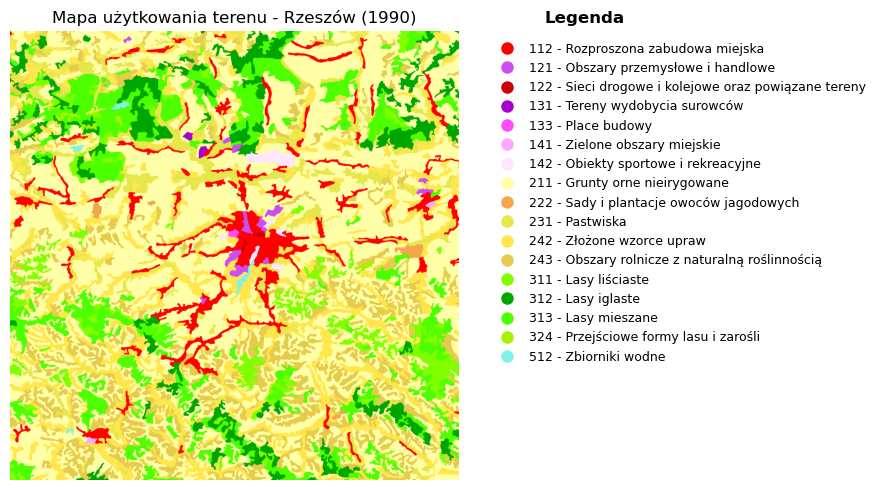

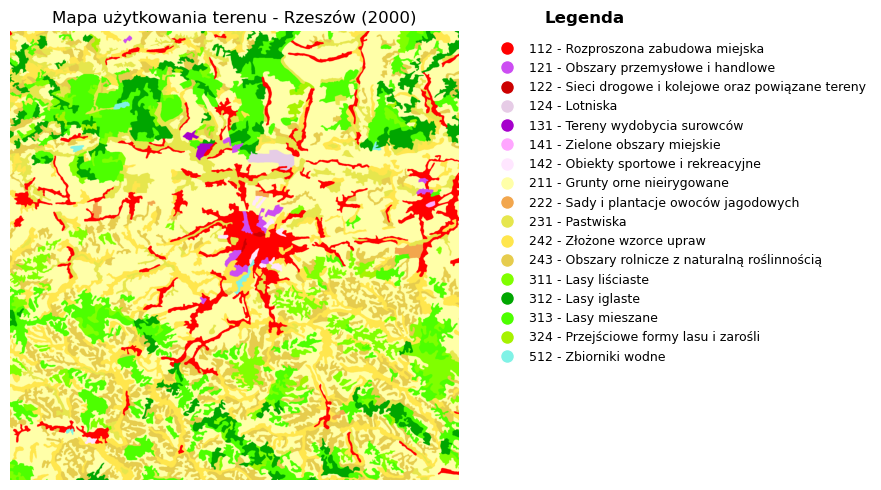

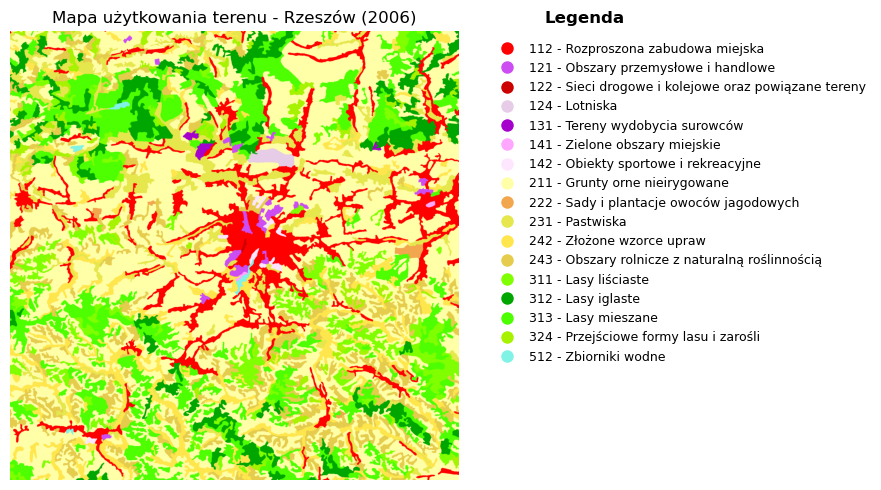

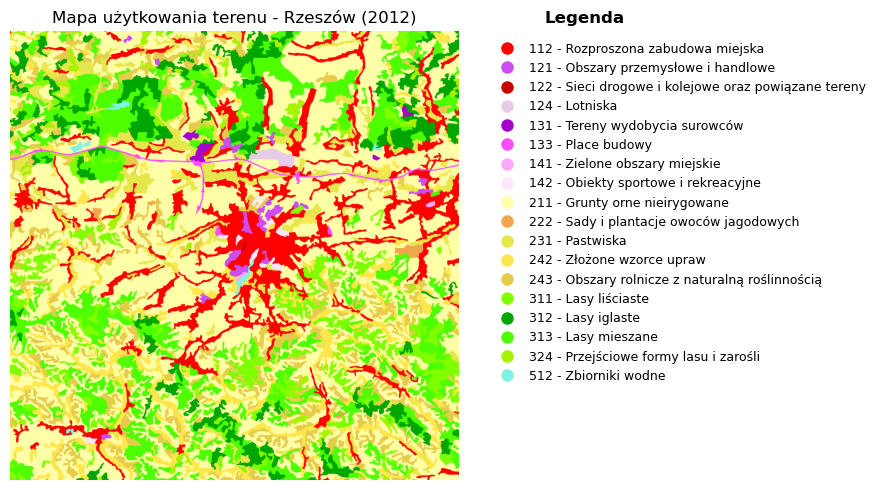

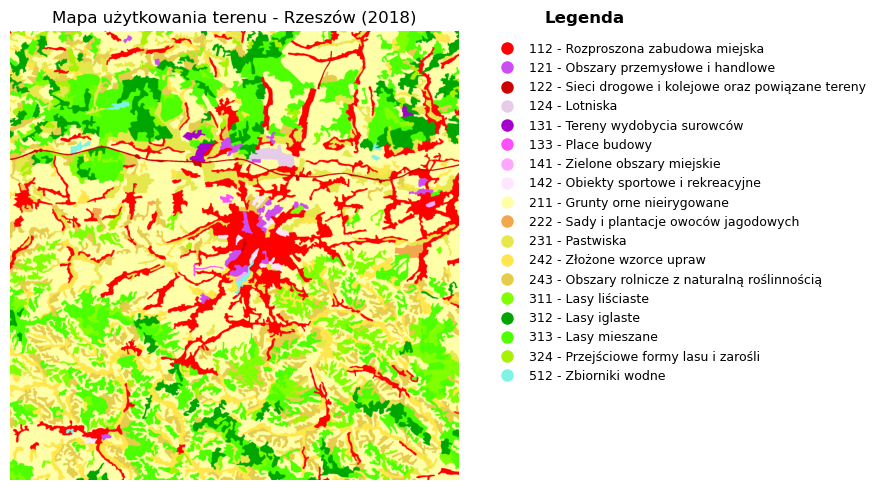

In [69]:
for year, img in images.items():
    fig, (ax_map, ax_legend) = plt.subplots(ncols=2, figsize=(10,5), gridspec_kw={'width_ratios': [3, 1]})

    # Wyświetlenie mapy
    ax_map.imshow(img)
    ax_map.axis("off")
    title_name = area_name.replace("_", " ").title()
    ax_map.set_title(f"Mapa użytkowania terenu - {title_name} ({year})")

    # Legenda
    ax_legend.axis("off")
    ax_legend.set_title("Legenda", fontsize=12, fontweight='bold')

    year_legend = unique_categories_per_year[year]

    legend_patches = [
        plt.Line2D(
            [0], [0],
            marker='o',
            color='w',
            markersize=10,
            markerfacecolor=np.array(k) / 255.0,
            label=v
        )
        for k, v in year_legend.items()
    ]

    ax_legend.legend(handles=legend_patches, loc="upper left", fontsize=9, frameon=False)

    plt.tight_layout()
    plt.show()